# 04 — Prophet Forecasting (RQ3: Prediction)

**Research Question:** Can Prophet forecast each stock's price trajectory over the next 90 days given current macro conditions (rate level + rate direction)? What does the model say under a 'rate hold' vs. 'one more hike' scenario?

**Method:** Train one Prophet model per Magnificent 7 stock with external regressors (Fed rate, CPI YoY, VIX). Generate 90-day forecasts under two scenarios and compare.

In [1]:
import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_fetcher import (
    fetch_stock_prices,
    fetch_macro_data,
    MAG7_TICKERS,
)
from src.forecaster import (
    prepare_prophet_data,
    train_prophet_model,
    run_scenario_comparison,
    forecast_all_stocks,
    export_forecast,
    VOLATILE_TICKERS,
)

sns.set_theme(style='whitegrid')
%matplotlib inline

/Users/thedarianwong/Developer/bigtech-fed-analysis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## 1. Load Data

In [2]:
prices = fetch_stock_prices()
macro = fetch_macro_data()

print(f"Prices: {prices.shape[0]} days, {prices.shape[1]} tickers")
print(f"Macro: {macro.shape[0]} days, columns: {list(macro.columns)}")
print(f"\nLatest macro values:")
print(f"  Fed Rate: {macro['fed_rate'].dropna().iloc[-1]:.2f}%")
print(f"  CPI YoY:  {macro['cpi_yoy'].dropna().iloc[-1]:.2f}%")
print(f"  VIX:      {prices['^VIX'].dropna().iloc[-1]:.1f}")

[*********************100%***********************]  9 of 9 completed


Prices: 2796 days, 9 tickers
Macro: 4061 days, columns: ['fed_rate', 'cpi', 'treasury_10y', 'gdp_growth', 'cpi_yoy']

Latest macro values:
  Fed Rate: 3.64%
  CPI YoY:  2.83%
  VIX:      20.6


## 2. Single Stock Demo — AAPL

Walk through the full process for one stock before running all seven.

In [3]:
# Prepare data
demo_ticker = 'AAPL'
df_demo = prepare_prophet_data(prices, macro, demo_ticker)
print(f"{demo_ticker} training data: {len(df_demo)} rows")
print(f"Date range: {df_demo['ds'].min().date()} to {df_demo['ds'].max().date()}")
df_demo.tail()

AAPL training data: 2544 rows
Date range: 2016-01-04 to 2026-02-13


,ds,y,fed_rate,cpi_yoy,vix
2539,2026-02-09,274.619995,3.64,2.82868,17.360001
2540,2026-02-10,273.679993,3.64,2.82868,17.790001
2541,2026-02-11,275.500000,3.64,2.82868,17.650000
2542,2026-02-12,261.730011,3.64,2.82868,20.820000
2543,2026-02-13,255.779999,3.64,2.82868,20.600000


In [4]:
# Train model
model_demo = train_prophet_model(df_demo)

# Run both scenarios
forecast_demo = run_scenario_comparison(model_demo, df_demo)
print(f"Forecast rows: {len(forecast_demo)} (2 scenarios x (history + 90 future days))")
forecast_demo[forecast_demo['ds'] > df_demo['ds'].max()].head(10)

02:46:49 - cmdstanpy - INFO - Chain [1] start processing
02:46:49 - cmdstanpy - INFO - Chain [1] done processing


Forecast rows: 5268 (2 scenarios x (history + 90 future days))


,ds,yhat,yhat_lower,yhat_upper,scenario
2544,2026-02-16,262.152810,249.687013,274.806588,hold
2545,2026-02-17,261.824574,250.051821,274.996660,hold
2546,2026-02-18,261.479807,249.334607,274.422107,hold
2547,2026-02-19,261.239852,248.659562,273.004634,hold
2548,2026-02-20,260.931590,248.095325,273.421932,hold
2549,2026-02-23,260.523575,248.011099,273.706671,hold
2550,2026-02-24,260.065859,248.264946,272.183563,hold
2551,2026-02-25,259.620277,247.114938,271.319740,hold
2552,2026-02-26,259.309274,248.242972,272.386450,hold
2553,2026-02-27,258.960274,246.624259,271.785154,hold


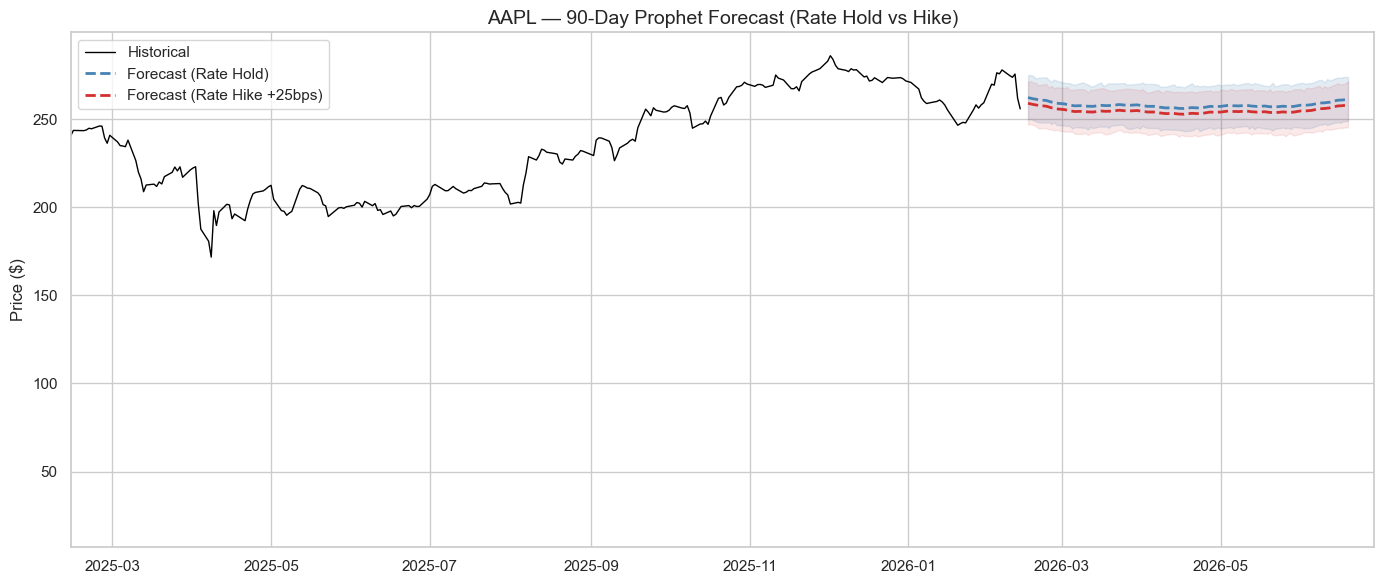

In [5]:
# Plot demo: historical + forecast with confidence bands
fig, ax = plt.subplots(figsize=(14, 6))

# Historical prices
ax.plot(df_demo['ds'], df_demo['y'], color='black', linewidth=1, label='Historical')

# Forecast — hold scenario
hold = forecast_demo[(forecast_demo['scenario'] == 'hold') & (forecast_demo['ds'] > df_demo['ds'].max())]
ax.plot(hold['ds'], hold['yhat'], color='steelblue', linewidth=2, linestyle='--', label='Forecast (Rate Hold)')
ax.fill_between(hold['ds'], hold['yhat_lower'], hold['yhat_upper'], alpha=0.15, color='steelblue')

# Forecast — hike scenario
hike = forecast_demo[(forecast_demo['scenario'] == 'hike') & (forecast_demo['ds'] > df_demo['ds'].max())]
ax.plot(hike['ds'], hike['yhat'], color='#d32f2f', linewidth=2, linestyle='--', label='Forecast (Rate Hike +25bps)')
ax.fill_between(hike['ds'], hike['yhat_lower'], hike['yhat_upper'], alpha=0.1, color='#d32f2f')

# Only show the last 365 days of history for clarity
ax.set_xlim(df_demo['ds'].max() - pd.Timedelta(days=365), hold['ds'].max() + pd.Timedelta(days=10))
ax.set_title(f'{demo_ticker} — 90-Day Prophet Forecast (Rate Hold vs Hike)', fontsize=14)
ax.set_ylabel('Price ($)')
ax.legend()
plt.tight_layout()
plt.show()

## 3. Forecast All Magnificent 7

Train and forecast all 7 stocks. NVDA and TSLA are capped to 2020+ training data due to volatile pre-AI era history.

In [6]:
print("Training Prophet models for all Magnificent 7 stocks...")
print(f"(Note: {VOLATILE_TICKERS} use training data from 2020 onward)\n")

all_forecasts = forecast_all_stocks(prices, macro, MAG7_TICKERS)

print(f"\nTotal forecast rows: {len(all_forecasts):,}")
print(f"Tickers: {sorted(all_forecasts['ticker'].unique())}")
print(f"Scenarios: {sorted(all_forecasts['scenario'].unique())}")

Training Prophet models for all Magnificent 7 stocks...
(Note: ['NVDA', 'TSLA'] use training data from 2020 onward)

  Training Prophet model for AAPL...


02:46:50 - cmdstanpy - INFO - Chain [1] start processing
02:46:50 - cmdstanpy - INFO - Chain [1] done processing
02:46:51 - cmdstanpy - INFO - Chain [1] start processing


  Training Prophet model for MSFT...


02:46:51 - cmdstanpy - INFO - Chain [1] done processing
02:46:52 - cmdstanpy - INFO - Chain [1] start processing


  Training Prophet model for NVDA...


02:46:52 - cmdstanpy - INFO - Chain [1] done processing
02:46:52 - cmdstanpy - INFO - Chain [1] start processing


  Training Prophet model for GOOGL...


02:46:52 - cmdstanpy - INFO - Chain [1] done processing
02:46:53 - cmdstanpy - INFO - Chain [1] start processing


  Training Prophet model for META...


02:46:53 - cmdstanpy - INFO - Chain [1] done processing
02:46:54 - cmdstanpy - INFO - Chain [1] start processing


  Training Prophet model for AMZN...


02:46:54 - cmdstanpy - INFO - Chain [1] done processing
02:46:55 - cmdstanpy - INFO - Chain [1] start processing
02:46:55 - cmdstanpy - INFO - Chain [1] done processing


  Training Prophet model for TSLA...

Total forecast rows: 32,852
Tickers: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
Scenarios: ['hike', 'hold']


## 4. Forecast Grid — All 7 Stocks

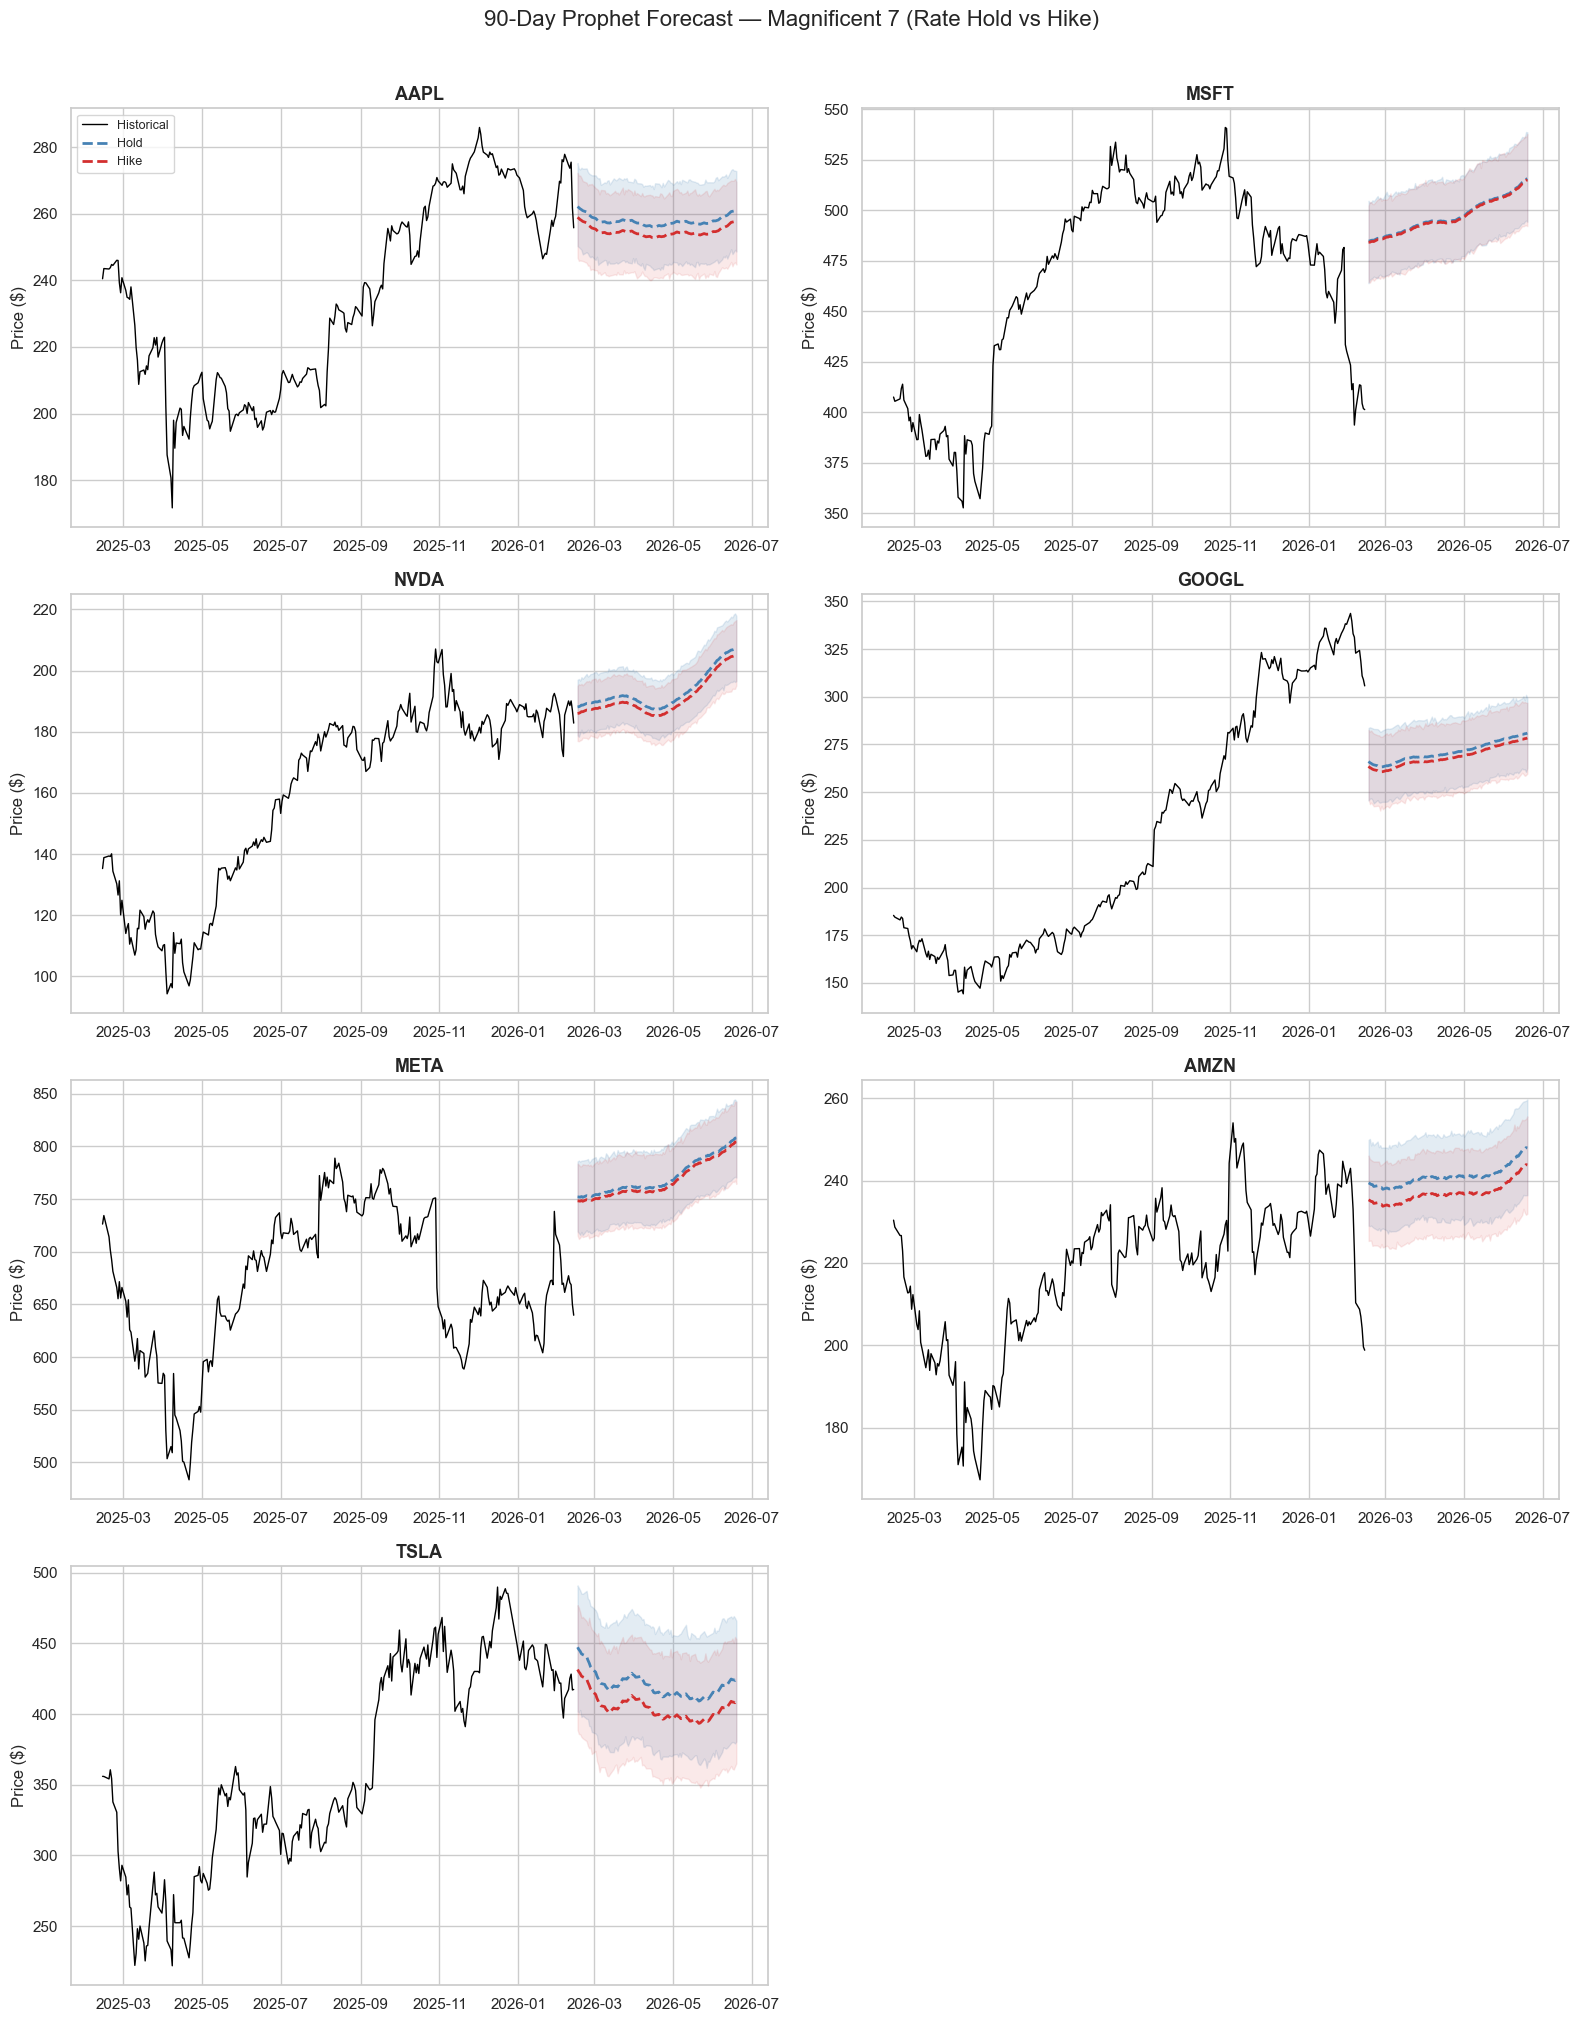

In [7]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
axes = axes.flatten()

last_historical_date = prices.index.max()

for i, ticker in enumerate(MAG7_TICKERS):
    ax = axes[i]

    # Historical (last 365 days)
    hist = prices[ticker].dropna()
    hist_recent = hist[hist.index >= last_historical_date - pd.Timedelta(days=365)]
    ax.plot(hist_recent.index, hist_recent.values, color='black', linewidth=1, label='Historical')

    # Hold forecast
    hold = all_forecasts[
        (all_forecasts['ticker'] == ticker) &
        (all_forecasts['scenario'] == 'hold') &
        (all_forecasts['ds'] > last_historical_date)
    ]
    ax.plot(hold['ds'], hold['yhat'], color='steelblue', linewidth=2, linestyle='--', label='Hold')
    ax.fill_between(hold['ds'], hold['yhat_lower'], hold['yhat_upper'], alpha=0.15, color='steelblue')

    # Hike forecast
    hike = all_forecasts[
        (all_forecasts['ticker'] == ticker) &
        (all_forecasts['scenario'] == 'hike') &
        (all_forecasts['ds'] > last_historical_date)
    ]
    ax.plot(hike['ds'], hike['yhat'], color='#d32f2f', linewidth=2, linestyle='--', label='Hike')
    ax.fill_between(hike['ds'], hike['yhat_lower'], hike['yhat_upper'], alpha=0.1, color='#d32f2f')

    ax.set_title(ticker, fontsize=13, fontweight='bold')
    ax.set_ylabel('Price ($)')
    if i == 0:
        ax.legend(fontsize=9)

# Hide the unused 8th subplot
axes[-1].set_visible(False)

plt.suptitle('90-Day Prophet Forecast — Magnificent 7 (Rate Hold vs Hike)', fontsize=16, y=1.01)
plt.tight_layout()
plt.show()

## 5. Scenario Impact Summary

How much does a 25bps rate hike change the 90-day forecast vs holding rates steady?

In [8]:
# Get the final day (90 days out) forecast for each ticker and scenario
future_only = all_forecasts[all_forecasts['ds'] > last_historical_date]
last_forecast_date = future_only['ds'].max()

endpoint = future_only[future_only['ds'] == last_forecast_date]

hold_end = endpoint[endpoint['scenario'] == 'hold'][['ticker', 'yhat']].rename(columns={'yhat': 'hold_price'})
hike_end = endpoint[endpoint['scenario'] == 'hike'][['ticker', 'yhat']].rename(columns={'yhat': 'hike_price'})

impact = hold_end.merge(hike_end, on='ticker')

# Add last known price for context
for ticker in MAG7_TICKERS:
    last_price = prices[ticker].dropna().iloc[-1]
    impact.loc[impact['ticker'] == ticker, 'current_price'] = last_price

impact['hold_return_pct'] = ((impact['hold_price'] - impact['current_price']) / impact['current_price']) * 100
impact['hike_return_pct'] = ((impact['hike_price'] - impact['current_price']) / impact['current_price']) * 100
impact['hike_penalty_pct'] = impact['hike_return_pct'] - impact['hold_return_pct']
impact = impact.sort_values('hike_penalty_pct')

print("=== 90-Day Forecast: Rate Hold vs +25bps Hike ===")
print(f"Forecast date: {last_forecast_date.date()}\n")
impact[['ticker', 'current_price', 'hold_price', 'hike_price', 'hold_return_pct', 'hike_return_pct', 'hike_penalty_pct']].round(2)

=== 90-Day Forecast: Rate Hold vs +25bps Hike ===
Forecast date: 2026-06-19



,ticker,current_price,hold_price,hike_price,hold_return_pct,hike_return_pct,hike_penalty_pct
6,TSLA,417.44,424.67,408.89,1.73,-2.05,-3.78
5,AMZN,198.79,247.90,243.78,24.71,22.63,-2.07
0,AAPL,255.78,261.25,258.02,2.14,0.88,-1.26
2,NVDA,182.81,207.17,205.03,13.33,12.15,-1.17
3,GOOGL,305.72,280.95,278.39,-8.10,-8.94,-0.84
4,META,639.77,808.03,804.26,26.30,25.71,-0.59
1,MSFT,401.32,515.70,515.08,28.50,28.35,-0.16


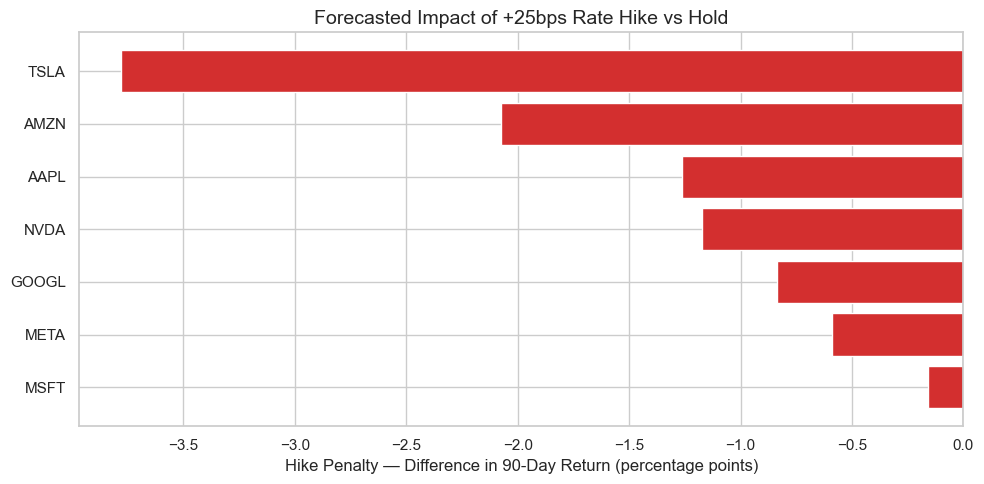

In [9]:
# Hike penalty bar chart
fig, ax = plt.subplots(figsize=(10, 5))

colors = ['#d32f2f' if v < 0 else '#388e3c' for v in impact['hike_penalty_pct']]
ax.barh(impact['ticker'], impact['hike_penalty_pct'], color=colors)
ax.axvline(x=0, color='black', linewidth=0.8)
ax.set_xlabel('Hike Penalty — Difference in 90-Day Return (percentage points)')
ax.set_title('Forecasted Impact of +25bps Rate Hike vs Hold', fontsize=14)
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 6. Key Insights

In [10]:
most_hurt = impact.iloc[0]
least_hurt = impact.iloc[-1]

print("=== Key Insights ===")
print(f"Most hurt by a hike:  {most_hurt['ticker']} — {most_hurt['hike_penalty_pct']:.2f}pp lower 90-day return")
print(f"Least hurt by a hike: {least_hurt['ticker']} — {least_hurt['hike_penalty_pct']:.2f}pp difference")
print(f"\nNote: These forecasts are illustrative, not predictive. Prophet captures")
print(f"historical patterns and regressor relationships but cannot account for")
print(f"earnings surprises, geopolitical events, or other confounders.")

=== Key Insights ===
Most hurt by a hike:  TSLA — -3.78pp lower 90-day return
Least hurt by a hike: MSFT — -0.16pp difference

Note: These forecasts are illustrative, not predictive. Prophet captures
historical patterns and regressor relationships but cannot account for
earnings surprises, geopolitical events, or other confounders.


## 7. Export for Tableau

In [11]:
export_forecast(all_forecasts)

Exported 32,852 rows to /Users/thedarianwong/Developer/bigtech-fed-analysis/output/prophet_forecast.csv
